In [271]:
import os
import requests
import urllib.request
from pathlib import Path
import pandas as pd
import time
import tweepy
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tweepy import OAuthHandler
from IPython.display import display, Markdown
from IPython.display import Image
import matplotlib.rcsetup as rcsetup

## Gathering The WeRateDogs Twitter Archive

In [222]:
# Reading in csv file as pandas dataframe, displayng a tuple of the array dimensions, and printing the first few rows.
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
print("Array Dimensions = ", twitter_archive.shape)
twitter_archive.head()

Array Dimensions =  (2356, 17)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Gathering The Tweet Image Predictions

In [218]:
# Using requests library to download tsv file
# putting a check so I don't have to redownload the file each time.

my_file_pred = Path("image_predictions.tsv")
if my_file_pred.exists():
    print("File already exists")
    
else:
    
    url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
    response = requests.get(url)

    with open('image_predictions.tsv', 'wb') as file:
        file.write(response.content)


File already exists


In [223]:
# Read tsv file into Pandas   
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
# Looking at the shape and the first couple of rows of the dataframe
print("Array Dimensions = ",image_predictions.shape)
image_predictions.head()
# Resources:  https://stackoverflow.com/questions/31126596/saving-response-from-requests-to-file

Array Dimensions =  (2075, 12)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Gathering Tweets from Twitter API

In [9]:
# Storing and loading passwords locally
password_list = pd.read_csv('password_list.csv')
consumer_key = password_list.consumer_key[0]
consumer_secret = password_list.consumer_secret[0]
access_token = password_list.access_token[0]
access_secret = password_list.access_secret[0]

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if (not api):
    print ("Error: Unable to Authenticate")
    sys.exit(-1)
    
# Put in error handling     
# Resource: https://www.karambelkar.info/2015/01/how-to-use-twitters-search-rest-api-most-effectively./

In [202]:
# For loop which to add each found tweet information to a new line of tweet_json.txt
# I put a file exist check because I kept adding to the file everytime I needed to rerun this cell.
missing_tweets = []
# Recording the missing tweets

my_file = Path("tweet_json.txt")
if my_file.exists():
    print("File already exists")
    
else:
    with open('tweet_json.txt', 'a', encoding='utf8') as f:
        # opening file in append mode
        for tweet_id in twitter_archive['tweet_id']:
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json.dump(tweet._json, f)
                f.write('\n')
            except:
                print('{} Tweet not found'.format(tweet_id))
                missing_tweets.append(tweet_id)

    print("File Created / Task Completed")
# Resources: https://docs.python.org/3/tutorial/inputoutput.html
# Resources:  https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy

File already exists


In [10]:
# Opening tweet_json to api_info

with open('tweet_json.txt', 'r') as fp:
    api_info = pd.read_json(fp, lines=True)
    
# Resources:  https://stackoverflow.com/questions/30088006/loading-a-file-with-more-than-one-line-of-json-into-pythons-pandas

In [211]:
# Viewing the columns in the api_info database.
api_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2346 non-null datetime64[ns]
display_text_range               2346 non-null object
entities                         2346 non-null object
extended_entities                2068 non-null object
favorite_count                   2346 non-null int64
favorited                        2346 non-null bool
full_text                        2346 non-null object
geo                              0 non-null float64
id                               2346 non-null int64
id_str                           2346 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [14]:
# Viewing the 3 columns I am interested in.
api_info[["id", "retweet_count", "favorite_count"]]

,id,retweet_count,favorite_count
0,892420643555336193,8726,39179
1,892177421306343426,6406,33544
2,891815181378084864,4256,25283
3,891689557279858688,8820,42532
4,891327558926688256,9605,40715
5,891087950875897856,3188,20411
6,890971913173991426,2122,11968
7,890729181411237888,19325,66197
8,890609185150312448,4348,28026
9,890240255349198849,7579,32246


In [208]:
# Moving the 3 columns into a separate variable
tweet_info = api_info[['id','retweet_count','favorite_count']]
tweet_info.info()
tweet_info.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 3 columns):
id                2346 non-null int64
retweet_count     2346 non-null int64
favorite_count    2346 non-null int64
dtypes: int64(3)
memory usage: 55.1 KB


(2346, 3)


## Exploring Data


In [18]:
# Looking at image prediction to get a feel for what I am looking at.  I will probably look into this category in more detail.
image_predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
web_site                      19
Cardigan                      19
Maltese_dog                   18
beagle                        18
Shetland_sheepdog             18
teddy                         18
Eskimo_dog                    18
Lakeland_terrier              17
Rottweiler                    17
Shih-Tzu                      17
Italian_greyhound             16
kuvasz                        16
          

In [19]:
# Looking at the second image classification to see how it differs from the first.
image_predictions.p2.value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
Pembroke                           27
Eskimo_dog                         27
collie                             27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
miniature_pinscher                 20
toy_terrier                        20
malinois                           20
chow                               20
Samoyed                            20
Boston_bull                        19
Norwegian_elkhound                 19
Staffordshir

In [20]:
# Looking at the different names and noticing that some do not make sense.
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Cooper        11
Lucy          11
Oliver        11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
the            8
Sadie          8
an             7
Toby           7
Bailey         7
Buddy          7
Daisy          7
Jax            6
Leo            6
Oscar          6
Scout          6
Dave           6
Milo           6
Koda           6
Bella          6
Jack           6
Rusty          6
Stanley        6
very           5
            ... 
Baron          1
Obie           1
Katie          1
Blakely        1
Mookie         1
Aubie          1
Trevith        1
Nida           1
Napolean       1
Stewie         1
Schnozz        1
Alf            1
Vince          1
Tycho          1
Grey           1
Jebberson      1
Cora           1
Terrenth       1
Hall           1
Harrison       1
Brutus         1
Chloe          1
Skittle        1
Ralphus        1
Duchess        1
Remus          1
Gunner         1
Ben           

In [21]:
# Looking through the text to see how many lines contain &amp
twitter_archive.text[twitter_archive.text.str.contains('&amp;')]

262     Meet Indie. She's not a fan of baths but she's...
273     RT @dog_rates: This is Pipsy. He is a fluffbal...
320     Meet Chester (bottom) &amp; Harold (top). They...
461     Say hello to Eugene &amp; Patti Melt. No matte...
485     RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur ...
516     Meet Sam. She smiles 24/7 &amp; secretly aspir...
799     Meet Roosevelt. He's preparing for takeoff. Ma...
889     Meet Maggie &amp; Lila. Maggie is the doggo, L...
898     This is Lilli Bee &amp; Honey Bear. Unfortunat...
976     Meet Jax &amp; Jil. Jil is yelling the pledge ...
1104    Meet Buckley. His family &amp; some neighbors ...
1179    Meet Sid &amp; Murphy. Murphy floats alongside...
1199    Meet Jennifur. She's supposed to be navigating...
1222    Meet Travis and Flurp. Travis is pretty chill ...
1274    From left to right:\nCletus, Jerome, Alejandro...
1366    Meet Rambo &amp; Kiwi. Rambo's the pup with th...
1421    Meet Beau &amp; Wilbur. Wilbur stole Beau's be...
1465    Meet O

### Assessing Data for this Project

After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. Detect and document at least eight (8) quality issues and two (2) tidiness issues in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the issues that satisfy the Project Motivation (see the Key Points header on the previous page) must be assessed.

#### List of Quality issues:

1.  Replace & amp; in text with just &.

2.  Convert id to string in tweet info dataframe.

3.  Rename tweet info id to tweet_id to merge it with the other two dataframes.

4.  Convert tweet_id to a string in image predictions dataframe.

5.  Convert tweet_id to a string in twitter archive dataframe.

6.  Convert datetime from string to datetime.

7.  Remove columns that contain no information, and the redundant dog stage columns.

8.  Some of the name records in Twitter Archive contain articles (the, an, a) instead of actual names.  I will rename them to None for consistency.

9.  Remove retweets

#### List of Tidiness Issues

1.  Merge all lists into a master list.

2.  Combine Dog Stages into one column.


## Cleaning Data


In [25]:
# Creating copies of the dataframe to clean
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_info_clean = tweet_info.copy()

In [39]:
# Viewing a summary of all of the copied dataframes

print("=" * 50)
twitter_archive_clean.info()
print("=" * 50)
image_predictions_clean.info()
print("=" * 50)
tweet_info_clean.info()
print("=" * 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [28]:
# Quality Issue 1
# Replacing &amp; with &.  Then verifying code works as expected.
twitter_archive_clean['text'] = twitter_archive_clean['text'].str.replace('&amp;','&')
twitter_archive_clean.text[twitter_archive_clean.text.str.contains('&amp;')]

Series([], Name: text, dtype: object)

In [206]:
# Quality Issue 2 and 3
# Changing id to tweet_id and converting it to string datatype

tweet_info_clean['id'] = tweet_info_clean['id'].astype(str)
tweet_info_clean.rename(columns={'id': 'tweet_id'}, inplace=True)
# Resources:  https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
tweet_info_clean["tweet_id"]

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
5       891087950875897856
6       890971913173991426
7       890729181411237888
8       890609185150312448
9       890240255349198849
10      890006608113172480
11      889880896479866881
12      889665388333682689
13      889638837579907072
14      889531135344209921
15      889278841981685760
16      888917238123831296
17      888804989199671297
18      888554962724278272
19      888078434458587136
20      887705289381826560
21      887517139158093824
22      887473957103951883
23      887343217045368832
24      887101392804085760
25      886983233522544640
26      886736880519319552
27      886680336477933568
28      886366144734445568
29      886267009285017600
               ...        
2316    666411507551481857
2317    666407126856765440
2318    666396247373291520
2319    666373753744588802
2320    666362758909284353
2321    666353288456101888
2

In [40]:
# Quality Issue 4
# We need to convert tweet id from a number to a string.
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)
tweet_info_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 3 columns):
id                2346 non-null int64
retweet_count     2346 non-null int64
favorite_count    2346 non-null int64
dtypes: int64(3)
memory usage: 55.1 KB


In [224]:
# Quality Issue 5
# We need to convert tweet id from a number to a string.
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

In [207]:
# Tidiness Issue 1
# Merging all three dataframes
tweet_merge_clean = pd.merge(tweet_info_clean, twitter_archive_clean, on='tweet_id', how='outer')
tweet_merge_clean = pd.merge(tweet_merge_clean, image_predictions_clean, on='tweet_id', how='outer')
tweet_merge_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4528 entries, 0 to 4708
Data columns (total 22 columns):
tweet_id              4528 non-null object
retweet_count         2346 non-null float64
favorite_count        2346 non-null float64
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
jpg_url               2075 non-null object
p1                    2075 non-null object
p1_conf               2075 non-null float64
p1_dog                2075 non-null object
p2                    2075 non-null object
p2_conf               2075 non-null float64
p2_dog                2075 non-null object
p3                    2075 non-null object
p3_conf               2075 non-null float64
p3_dog                2075 non-null object
dog_stage         

In [204]:
# Quality Issue 6
# Converting to datetime
tweet_merge_clean['timestamp'] =  pd.to_datetime(tweet_merge_clean['timestamp'], infer_datetime_format=True)
tweet_merge_clean.timestamp

0                      NaT
1                      NaT
2                      NaT
3                      NaT
4                      NaT
5                      NaT
6                      NaT
7                      NaT
8                      NaT
9                      NaT
10                     NaT
11                     NaT
12                     NaT
13                     NaT
14                     NaT
15                     NaT
16                     NaT
17                     NaT
18                     NaT
19                     NaT
20                     NaT
21                     NaT
22                     NaT
23                     NaT
24                     NaT
25                     NaT
26                     NaT
27                     NaT
28                     NaT
29                     NaT
               ...        
4679   2015-11-16 19:31:45
4680   2015-11-16 16:37:02
4681   2015-11-16 16:11:11
4682   2015-11-16 15:14:19
4683   2015-11-16 14:57:41
4684   2015-11-16 04:02:55
4

In [203]:
# Tidiness Issue 2
# I will be merging all the dog stage columns into one column.
tweet_merge_clean['dog_stage'] = tweet_merge_clean.apply(lambda row: row['doggo'] + row['floofer'] + row['pupper'] + row['puppo'], axis=1)
# Running a value count on the dog stage column.
tweet_merge_clean.dog_stage.value_counts()

# Resources https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns
# Results in a new column named dog_stage that is a result of the 4 columns combined

None                 1831
Pupper                224
Doggo                  75
Puppo                  24
Doggo and Pupper       10
Floofer                 9
Doggo and Puppo         1
Doggo and Floofer       1
Name: dog_stage, dtype: int64

In [69]:
# Tidiness Issue 2
# Replacing all the values in dog stage into easier to understand terms.
dogstage_replace_values = {'NoneNoneNoneNone' : "None", "doggoNoneNoneNone" : "Doggo", 
                           "NoneflooferNoneNone" : "Floofer", 
                           "NoneNonepupperNone" : "Pupper",  
                           "NoneNoneNonepuppo" : "Puppo",  
                           "doggoNonepupperNone" : "Doggo and Pupper", 
                           "doggoflooferNoneNone" : "Doggo and Floofer",  
                           "doggoNoneNonepuppo" : "Doggo and Puppo"}
tweet_merge_clean = tweet_merge_clean.replace({"dog_stage": dogstage_replace_values})  
tweet_merge_clean.dog_stage.value_counts()

# Resources:  https://stackoverflow.com/questions/22100130/pandas-replace-multiple-values-one-column

In [71]:
# Quality Issue 7
# Dropping the 4 redundant columns, 3 empty columns, img_num and both in reply columns
tweet_merge_clean = tweet_merge_clean.drop(['doggo', 'floofer', 'pupper', 
            'puppo', "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp", 
            'in_reply_to_status_id', 'in_reply_to_user_id', 'img_num'], axis=1)


In [65]:
# Quality Issue 8
tweet_merge_clean.name.value_counts()

None        680
a            55
Lucy         11
Charlie      11
Oliver       10
Cooper       10
Tucker        9
Penny         9
Lola          8
Winston       8
the           8
Sadie         8
Daisy         7
Toby          7
Bo            6
Bailey        6
Bella         6
an            6
Jax           6
Oscar         6
Koda          6
Stanley       6
Chester       5
Bentley       5
Milo          5
Leo           5
Dave          5
Louis         5
Scout         5
Rusty         5
           ... 
Vinscent      1
by            1
Dunkin        1
Sailer        1
Chloe         1
Brutus        1
Hall          1
Napolean      1
Terrance      1
Robin         1
Cal           1
Shaggy        1
Derby         1
Kloey         1
Corey         1
Trip          1
Antony        1
Nida          1
Rizzy         1
Stewie        1
Schnozz       1
Alf           1
Vince         1
Tycho         1
Grey          1
Hercules      1
Cora          1
Terrenth      1
Leela         1
Bodie         1
Name: name, Length: 956,

In [66]:
# Quality Issue 8
# Looking at name I will change a, the, an, and very to None
name_replace_values = {'a' : "None", "the" : "None", "an" : "None", "very" : "None"}
tweet_merge_clean = tweet_merge_clean.replace({"name": name_replace_values})  

# Resources:  https://stackoverflow.com/questions/22100130/pandas-replace-multiple-values-one-column

In [205]:
# Quality Issue 9
# Clearing out the retweets
tweet_merge_clean = tweet_merge_clean[tweet_merge_clean['retweeted_status_id'].isnull()]
tweet_merge_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4528 entries, 0 to 4708
Data columns (total 22 columns):
tweet_id              4528 non-null object
retweet_count         2346 non-null float64
favorite_count        2346 non-null float64
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
jpg_url               2075 non-null object
p1                    2075 non-null object
p1_conf               2075 non-null float64
p1_dog                2075 non-null object
p2                    2075 non-null object
p2_conf               2075 non-null float64
p2_dog                2075 non-null object
p3                    2075 non-null object
p3_conf               2075 non-null float64
p3_dog                2075 non-null object
dog_stage         

### Storing, Analyzing, and Visualizing Data for this Project

Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv. If additional files exist because multiple tables are required for tidiness, name these files appropriately. Additionally, you may store the cleaned data in a SQLite database (which is to be submitted as well if you do).



In [76]:
# Saving cleaned dataframe to csv file.
tweet_merge_clean.to_csv('twitter_archive_master.csv')

In [91]:
total_rating = tweet_merge_clean['rating_numerator'] / tweet_merge_clean['rating_denominator']

### Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least three (3) insights and one (1) visualization must be produced.

### Insights

In [93]:
# Insight 1 
# I wanted to find out which dogs breeds were identified the most via the neural network.
breeds = tweet_merge_clean.groupby(by='p1')

In [151]:
# Insight 1
# I then organized it by the top 5 identified breeds

top_breeds = breeds.agg({'p1': 'count', 'favorite_count': 'mean', 'retweet_count': 'mean'}).sort_values('p1')[-5:]
top_breeds = top_breeds.rename(columns={'p1':'Count', 'favorite_count':'Favorite Count', 'retweet_count':'Retweet Count'})
top_breeds = top_breeds.reset_index()
top_breeds = top_breeds.rename(columns={'p1':'Breed'})

breed_replace_values = {'pug': 'Pug', 'Labrador_retriever': 'Labrador', 'golden_retriever':'Golden Retriever'}
top_breeds = top_breeds.replace({"Breed": breed_replace_values})  
top_breeds

# Resources:  https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.agg.html

,Breed,Count,Favorite Count,Retweet Count
0,Pug,57,5554.105263,1949.754386
1,Chihuahua,83,8484.135802,3022.543210
2,Pembroke,89,11299.897727,3157.795455
3,Labrador,100,11108.120000,4206.930000
4,Golden Retriever,150,11383.409396,3843.255034


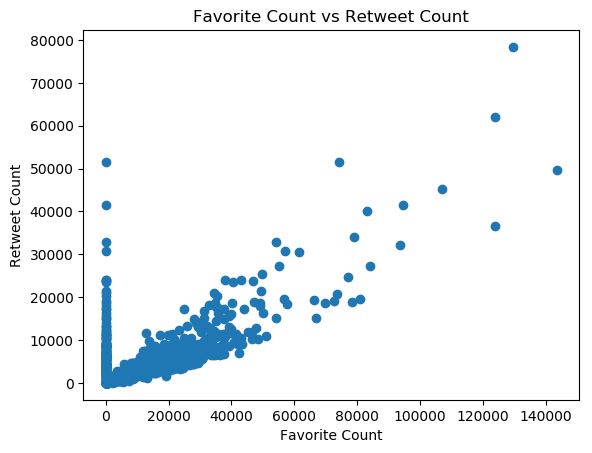

In [266]:
# Insight 2
# As we see from the scatterplot below there appears to be a positive linear relationship between the number 
# of retweets and favorites that a picture has.

# Scatterplot favorite_count vs retweet_count
plt.scatter(x=tweet_merge_clean['favorite_count'], y=tweet_merge_clean['retweet_count'])
plt.xlabel('Favorite Count');
plt.ylabel('Retweet Count');
plt.title('Favorite Count vs Retweet Count');
plt.style.use('default')
plt.show()
#plt.savefig('favretweet.png')
plt.gcf().clear()


                tweet_id  retweet_count  favorite_count timestamp source text  \
407   822872901745569793        49733.0        143493.0       NaT    NaN  NaN   
1029  744234799360020481        78386.0        129565.0       NaT    NaN  NaN   
528   807106840509214720        61978.0        123976.0       NaT    NaN  NaN   

     expanded_urls  rating_numerator  rating_denominator name     ...       \
407            NaN               NaN                 NaN  NaN     ...        
1029           NaN               NaN                 NaN  NaN     ...        
528            NaN               NaN                 NaN  NaN     ...        

       p1_conf p1_dog                  p2   p2_conf p2_dog             p3  \
407   0.196015   True  Labrador_retriever  0.160329   True  Irish_terrier   
1029  0.825333   True            ice_bear  0.044681  False        whippet   
528   0.505370   True          Pomeranian  0.120358   True    toy_terrier   

       p3_conf p3_dog  dog_stage total_rating  
407  

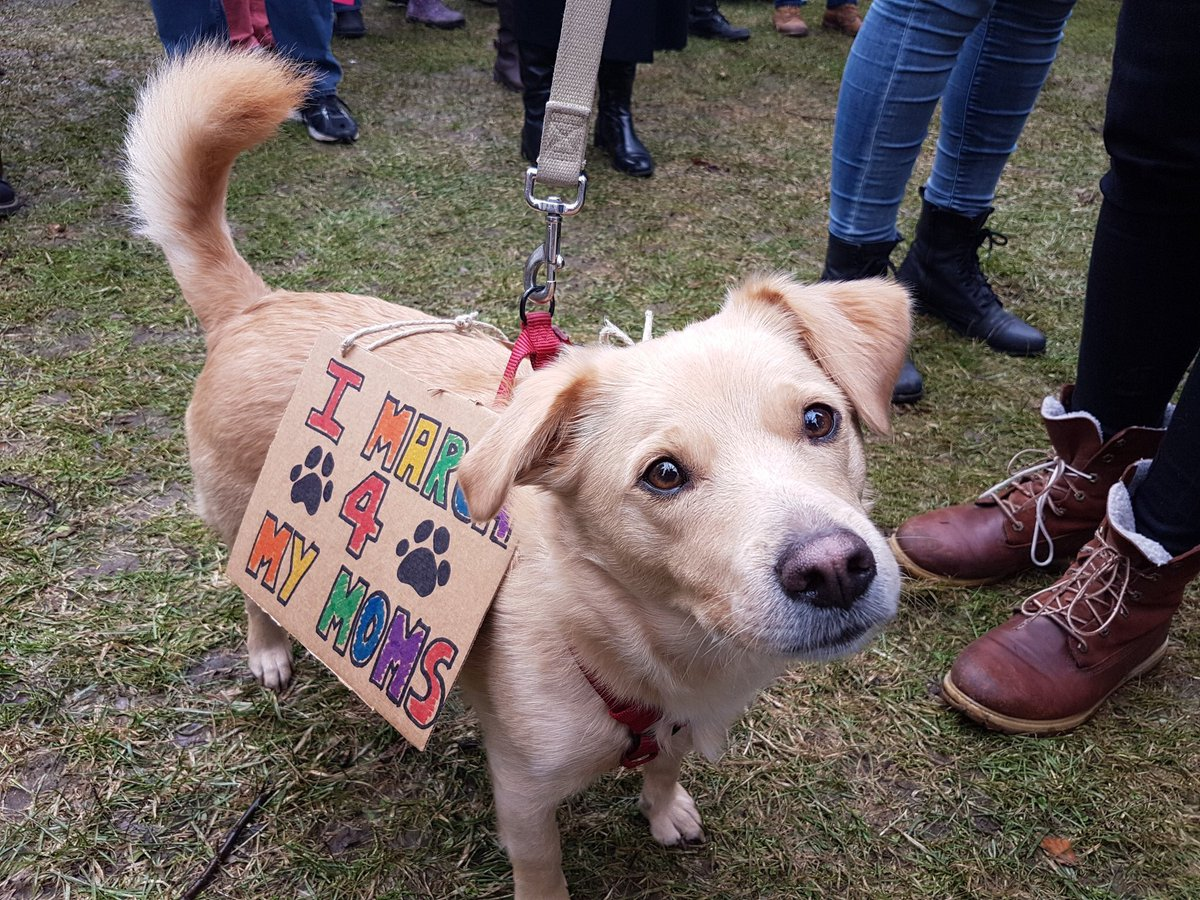

In [275]:
# Insight 3
# I sorted via the 3 largest numbers in favorite count and then looked up the picture of the dog with the largest 
# favorite count and placed it below.

print (tweet_merge_clean.nlargest(3, 'favorite_count'))
Image("https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg")
#Resources: https://stackoverflow.com/questions/16958499/sort-pandas-dataframe-and-print-highest-n-values

                tweet_id  retweet_count  favorite_count timestamp source text  \
1029  744234799360020481        78386.0        129565.0       NaT    NaN  NaN   
528   807106840509214720        61978.0        123976.0       NaT    NaN  NaN   
808   770743923962707968        51607.0             0.0       NaT    NaN  NaN   

     expanded_urls  rating_numerator  rating_denominator name     ...       \
1029           NaN               NaN                 NaN  NaN     ...        
528            NaN               NaN                 NaN  NaN     ...        
808            NaN               NaN                 NaN  NaN     ...        

       p1_conf p1_dog          p2   p2_conf p2_dog           p3   p3_conf  \
1029  0.825333   True    ice_bear  0.044681  False      whippet  0.018442   
528   0.505370   True  Pomeranian  0.120358   True  toy_terrier  0.077008   
808        NaN    NaN         NaN       NaN    NaN          NaN       NaN   

     p3_dog  dog_stage total_rating  
1029   True    

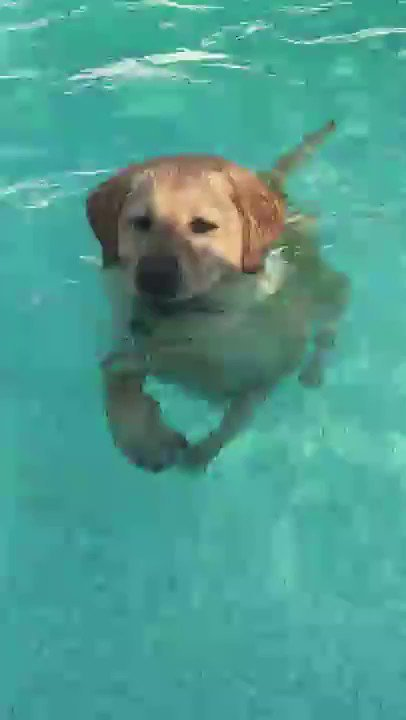

In [274]:
#Insight 4
#I sorted via the 3 largest numbers in retweet count and then looked up the picture of the dog with the largest 
#retweet count and placed it below. 

print (tweet_merge_clean.nlargest(3, 'retweet_count'))
Image("https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg")
#Resources: https://stackoverflow.com/questions/16958499/sort-pandas-dataframe-and-print-highest-n-values

### Visualization

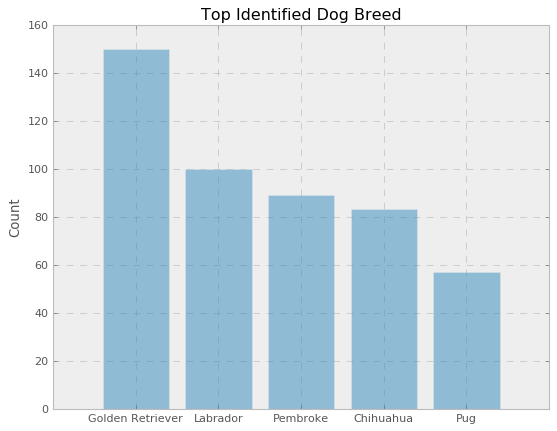

In [259]:
# Visualization from Insight 1
# I created the visualization below to display the 5 most popular dog breeds identified by neural network. 
y_pos = np.arange(len(top_breeds))
x_pos = top_breeds.Count
 
plt.bar(y_pos, x_pos, align='center', alpha=0.5)
plt.xticks(y_pos, top_breeds.Breed)
plt.ylabel('Count')
plt.title('Top Identified Dog Breed')
plt.style.use('bmh')
#plt.savefig('breed.png') 
plt.show()
plt.gcf().clear()
# Resources: https://pythonspot.com/matplotlib-bar-chart/

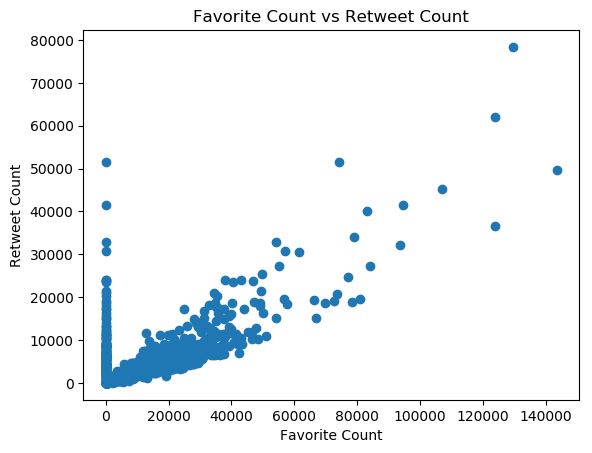

In [276]:
# Visualization from Insight 2
plt.scatter(x=tweet_merge_clean['favorite_count'], y=tweet_merge_clean['retweet_count'])
plt.xlabel('Favorite Count');
plt.ylabel('Retweet Count');
plt.title('Favorite Count vs Retweet Count');
plt.style.use('default')
plt.show()
#plt.savefig('favretweet.png')
plt.gcf().clear()

Reporting for this Project
Create a 300-600 word written report called wrangle_report.pdf that briefly describes your wrangling efforts. This is to be framed as an internal document.

Create a 250-word-minimum written report called act_report.pdf that communicates the insights and displays the visualization(s) produced from your wrangled data. This is to be framed as an external document, like a blog post or magazine article, for example.

Both of these documents can be created in separate Jupyter Notebooks using the Markdown functionality of Jupyter Notebooks, then downloading those notebooks as PDF files (see image below). You might prefer to use a word processor like Google Docs or Microsoft Word, however.